In [22]:
import sys
import os
import subprocess

import numpy as np
from scipy.interpolate import splrep,splev
import matplotlib.pyplot as plt
import astropy.units as u
from synthesizAR.instruments import InstrumentSDOAIA

sys.path.append(os.path.join(os.environ['HOME'],'Documents/work/codes/ebtelPlusPlus/rsp_toolkit/python'))
from xml_io import InputHandler,OutputHandler

%matplotlib inline

Configure the EBTEL simulation

In [512]:
config = InputHandler(os.path.join(os.environ['HOME'],
                                   'Documents/work/codes/ebtelPlusPlus/config/ebtel.example.cfg.xml')
                     ).lookup_vars()

Configure basic parameters

In [513]:
config['use_adaptive_solver'] = True
config['use_flux_limiting'] = True
config['total_time'] = 2e4
config['output_filename'] = 'heating_timelag_test'
config['adaptive_solver_error'] = 1e-8

Setup heating function

In [521]:
config['heating']['events'] = []
num_events = 80
max_heating_rate = 1e0
delay = 250
duration = 400
for i in range(num_events):
    config['heating']['events'].append(
        {'event':{'rise_start':i*delay,
                  'rise_end':i*delay+duration/2.,
                  'decay_start':i*delay+duration/2.,
                  'decay_end':i*delay+duration,
                  'magnitude':max_heating_rate*i/(num_events/2) if i<num_events/2 else max_heating_rate*(2 - i/(num_events/2))
                 }
        })

Run Simulation and read in data.

In [522]:
OutputHandler('.'.join([config['output_filename'],'xml']),config).print_to_xml()

In [523]:
subprocess.call([os.path.join(os.environ['HOME'],'Documents','work','codes','ebtelPlusPlus','bin','ebtel++.run'),
                 '-c',config['output_filename']+'.xml'])

0

In [524]:
data = np.loadtxt(config['output_filename'])
t = data[:,0]*u.s
Te = data[:,1]*u.K
Ti = data[:,2]*u.K
n = data[:,3]/(u.cm**3)
h = data[:,-1]*u.erg/(u.cm**3)/u.s

Load the AIA instrument so we can calculate the response functions.

In [525]:
aia = InstrumentSDOAIA([0,config['total_time']]*u.s)

In [526]:
intensity = {}
for channel in aia.channels:
    interp_Te = splev(aia.observing_time.value,splrep(t.value,Te.value))*u.K
    interp_n = splev(aia.observing_time.value,splrep(t.value,n.value))/(u.cm**3)
    k = splev(interp_Te.value,channel['temperature_response_spline'])*u.count*u.cm**5/u.s/u.pixel
    intensity[channel['name']] = (interp_n**2)*k*(config['loop_length']*u.cm)

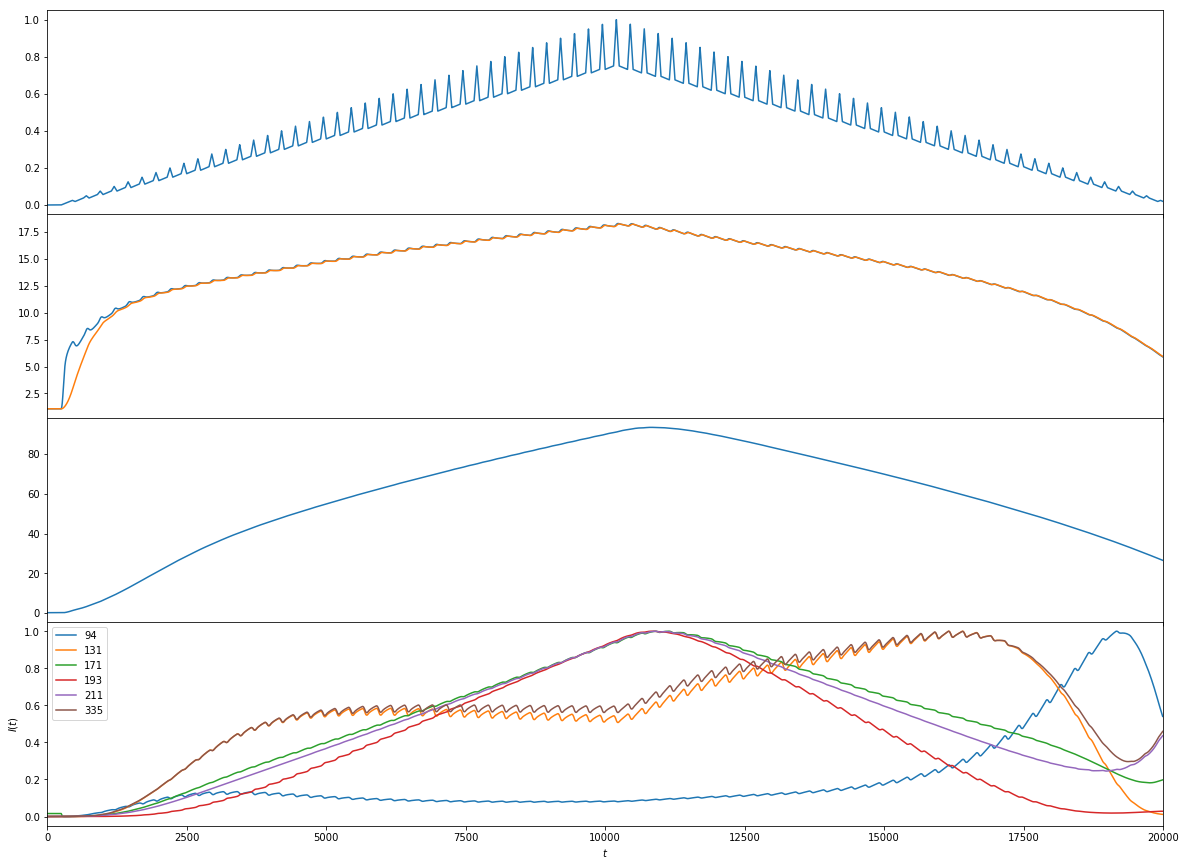

In [527]:
fig,axes = plt.subplots(4,1,figsize=(20,15),sharex=True)
plt.subplots_adjust(hspace=0)
axes[0].plot(t,h)
axes[1].plot(t,Te.to(u.MK))
axes[1].plot(t,Ti.to(u.MK))
axes[2].plot(t,n/1e9)
for channel in aia.channels:
    axes[3].plot(aia.observing_time,
                 intensity[channel['name']]/np.max(intensity[channel['name']]),
                 label=channel['name'])
axes[3].set_ylabel(r'$I(t)$')
axes[3].set_xlabel(r'$t$')
#axes[3].set_yscale('log')
#axes[3].set_ylim([1,1e6])
axes[0].set_xlim([0,config['total_time']])
axes[3].legend()

Finally, calculate the timelags between channel pairs.

In [528]:
timelags = np.hstack([-aia.observing_time.value[1:][::-1],aia.observing_time.value])*aia.observing_time.unit

In [529]:
pairs = [('335','171'),('94','171'),('171','131'),('193','171'),('335','211'),('94','335')]

(-19990.0, 19990.0)

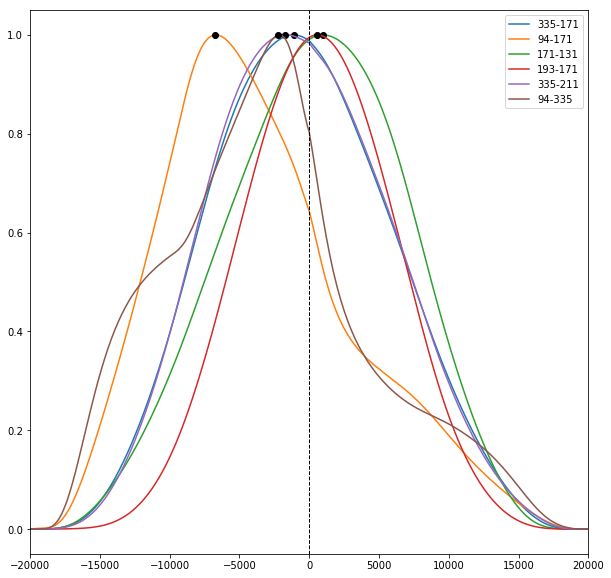

In [530]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
for p in pairs:
    ts_a = intensity[p[0]]/np.max(intensity[p[0]])
    ts_b = intensity[p[1]]/np.max(intensity[p[1]])
    cc = np.fft.irfft(np.fft.rfft(ts_a[::-1],n=timelags.shape[0])
                      *np.fft.rfft(ts_b,n=timelags.shape[0]),n=timelags.shape[0])
    ax.plot(timelags,cc/cc.max(),label=r'{}-{}'.format(*p))
    ax.plot(timelags[np.argmax(cc)],1,'ko')
ax.legend(loc='best')
ax.axvline(x=0,ls='--',color='k',lw=1)
ax.set_xlim([timelags[0].value,timelags[-1].value])

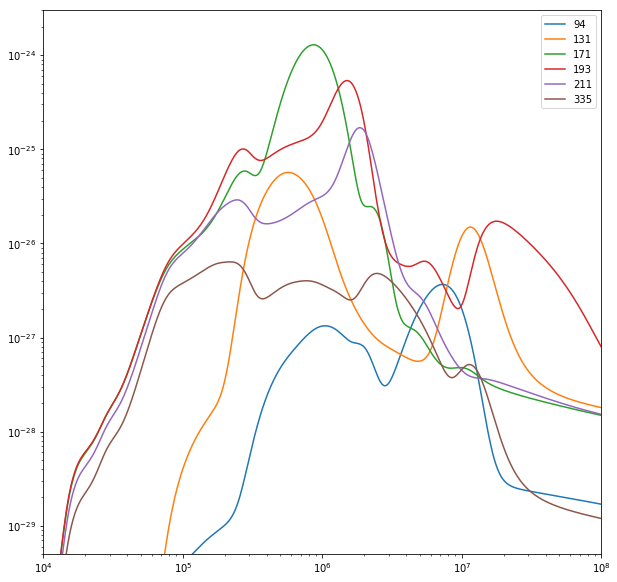

In [358]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
resp_temp = np.logspace(4,8,1000)
for channel in aia.channels:
    k = splev(resp_temp,channel['temperature_response_spline'])
    ax.plot(resp_temp,k,label=r'{}'.format(channel['name']))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([resp_temp[0],resp_temp[-1]])
ax.set_ylim([5e-30,3e-24])
ax.legend(loc='best')